In [1]:
import pandas as pd

def get_sorted_descriptions_from_dict(x, y):
    # Create lists for different conditions
    start = [item['Description'] for item in x if item['IsStart'] == True]
    middle = [item['Description'] for item in x if item['IsStart'] != True and item['IsEnd'] != True]
    middle.sort(key = lambda x : int(x[1:]))
    end = [item['Description'] for item in x if item['IsEnd'] == True]

    # Augment the smaller classes
    if y == "6B" or len(middle) < 4:
        return [start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"]]
    else:
        
        out = [start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"]]
        middle[0], middle[1] = middle[1], middle[0]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        middle[0], middle[1] = middle[1], middle[0]
        middle[-1], middle[-2] = middle[-2], middle[-1]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        middle[0], middle[1] = middle[1], middle[0]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        return out
    

def preprocess_data(filename, necessary_columns):
    # read into dataframe
    df = pd.read_json(filename).T
    df = df[necessary_columns]

    # remove low quality classes
    df = df[df['Grade']!='8B+']
    df = df[df['Grade']!='8B']
    df = df[df['Grade']!='8A+']

    df = df.reset_index(drop=True)

    # get tokenised list for each route
    X, y = df["Moves"], df["Grade"]
    n = len(X)
    data = []
    for i in range(n):
        data += get_sorted_descriptions_from_dict(X[i],y[i]) 
    

    return data

def drop_duplicates(list_of_lists):
    # Convert each inner list to a tuple (tuples are hashable and can be added to a set)
    seen = set()
    unique_list_of_lists = [tuple(lst) for lst in list_of_lists if tuple(lst) not in seen and not seen.add(tuple(lst))]

    # Convert tuples back to lists
    return [list(tpl) for tpl in unique_list_of_lists]

columns = ["Method", "Grade", "Name", "Rating", "Repeats", "Moves"]

data = preprocess_data("Raw\moonboard_problems_setup_2016.json", columns)
print(len(data))

data = drop_duplicates(data)
print(len(data))

92295
92127


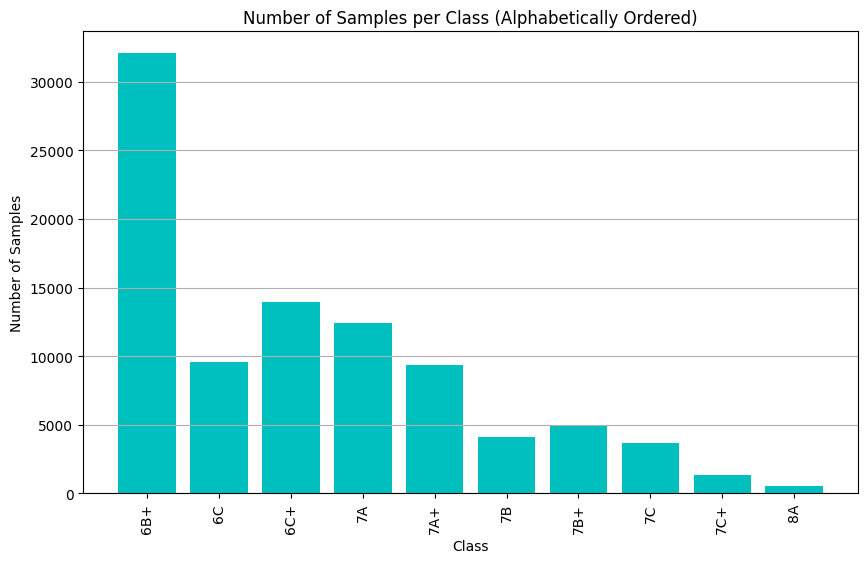

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the classes (grades) from the dataset
classes = [d[-2] for d in data]

# Count the number of occurrences of each class
class_counts = Counter(classes)

# Sort class labels alphabetically
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_counts, color='c')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Alphabetically Ordered)')
plt.xticks(rotation=90)  # Rotate x labels if they are long
plt.grid(axis='y')

plt.show()


# LSTM Classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Custom dataset
class ClimbingRouteDataset(Dataset):
    def __init__(self, sequences, grades, vocab, max_length):
        self.sequences = sequences
        self.grades = grades
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        grade = self.grades[idx]
        
        seq_indices = [self.vocab.get(hold, 0) for hold in sequence]
        seq_indices = seq_indices[:self.max_length] + [0] * (self.max_length - len(seq_indices))
        
        return torch.tensor(seq_indices), torch.tensor(grade)

# LSTM model
class ClimbingGradePredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, grades in train_loader:
        sequences, grades = sequences.to(device), grades.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, grades)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, grades in test_loader:
            sequences, grades = sequences.to(device), grades.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, grades)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += grades.size(0)
            correct += (predicted == grades).sum().item()
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

def plot_loss_curves(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
# Sample data (replace with your full dataset)
sequences = data
grades = [s[-2] for s in sequences]
sequences = [s[:-2] for s in sequences]

# Create vocabulary and encode grades
vocab = {hold: idx for idx, hold in enumerate(set(hold for seq in sequences for hold in seq), start=1)}
vocab['<PAD>'] = 0
grade_encoder = LabelEncoder()
encoded_grades = grade_encoder.fit_transform(grades)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_grades, test_size=0.2, random_state=42)

# Create datasets and dataloaders
max_length = max(len(seq) for seq in sequences)
train_dataset = ClimbingRouteDataset(X_train, y_train, vocab, max_length)
test_dataset = ClimbingRouteDataset(X_test, y_test, vocab, max_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClimbingGradePredictor(
    vocab_size=len(vocab),
    embed_dim=16,
    hidden_dim=128,
    num_layers=3,
    num_classes=len(grade_encoder.classes_)
).to(device)

# Class weights for balanced training
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = np.log(class_weights + np.e)
print("Class Weighting in Loss Function")
for k in list(zip(grade_encoder.classes_, class_weights)):
        print(k)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

optimizer = optim.Adam(model.parameters(), lr=0.001)


Class Weighting in Loss Function
('6B+', 1.100437555088908)
('6C', 1.3038525094321243)
('6C+', 1.2178374535560184)
('7A', 1.2419072185815996)
('7A+', 1.3077102234046691)
('7B', 1.6004041271921927)
('7B+', 1.5203433686767018)
('7C', 1.641942697035619)
('7C+', 2.249822343011615)
('8A', 2.9251179655913444)


In [10]:
# Training loop
num_epochs = 500
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/500, Train Loss: 1.6401, Test Loss: 1.6271, Test Accuracy: 0.4088
Epoch 2/500, Train Loss: 1.6012, Test Loss: 1.6072, Test Accuracy: 0.4127
Epoch 3/500, Train Loss: 1.5581, Test Loss: 1.5604, Test Accuracy: 0.4272
Epoch 4/500, Train Loss: 1.5195, Test Loss: 1.5235, Test Accuracy: 0.4365
Epoch 5/500, Train Loss: 1.4764, Test Loss: 1.5041, Test Accuracy: 0.4414
Epoch 6/500, Train Loss: 1.4250, Test Loss: 1.4758, Test Accuracy: 0.4485
Epoch 7/500, Train Loss: 1.3652, Test Loss: 1.4313, Test Accuracy: 0.4633
Epoch 8/500, Train Loss: 1.3009, Test Loss: 1.4046, Test Accuracy: 0.4729
Epoch 9/500, Train Loss: 1.2359, Test Loss: 1.3696, Test Accuracy: 0.4801
Epoch 10/500, Train Loss: 1.1632, Test Loss: 1.3301, Test Accuracy: 0.5168
Epoch 11/500, Train Loss: 1.0910, Test Loss: 1.3497, Test Accuracy: 0.5245
Epoch 12/500, Train Loss: 1.0158, Test Loss: 1.2804, Test Accuracy: 0.5450
Epoch 13/500, Train Loss: 0.9375, Test Loss: 1.2615, Test Accuracy: 0.5598
Epoch 14/500, Train Loss: 0.8612, 

KeyboardInterrupt: 

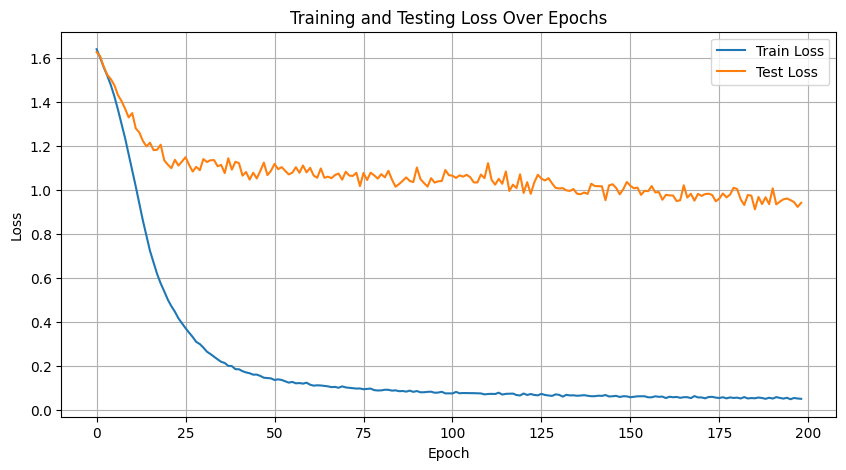

In [11]:
# Plot training and testing loss curves
plot_loss_curves(train_losses, test_losses)

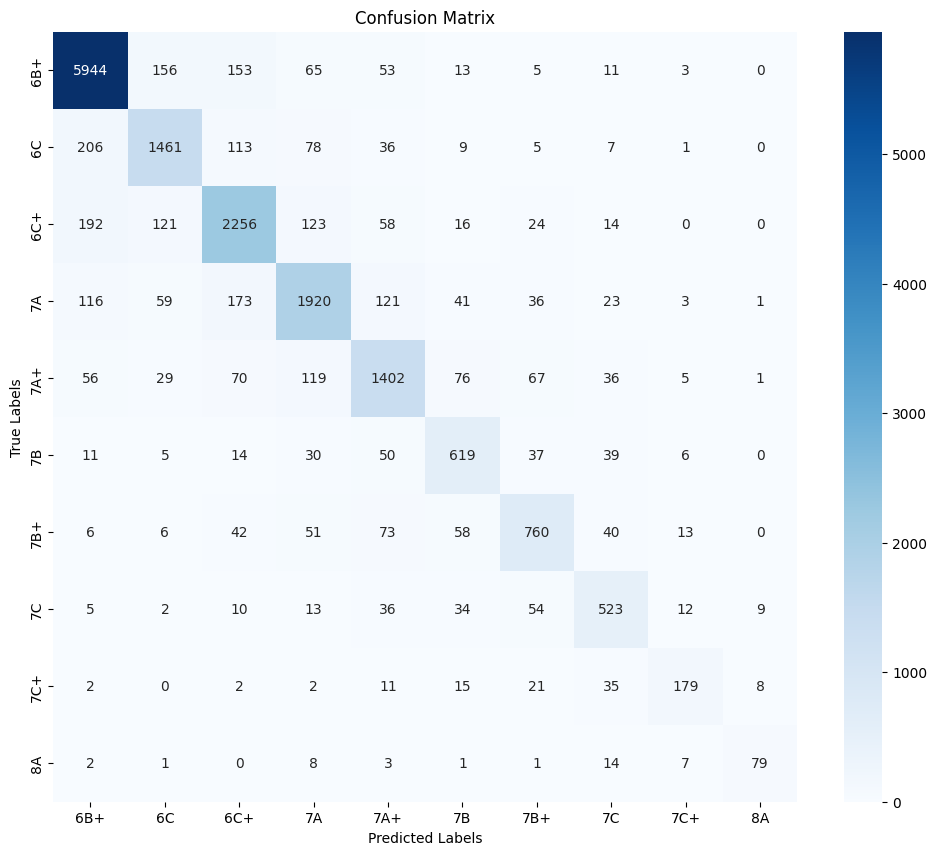

Majority Class Size: 0.3474981005101487
Accuracy 1: 0.8218278519483339
Accuracy 2: 0.9037230001085422
Accuracy 3: 0.9553348529252144
Accuracy 4: 0.9801367632692934
Accuracy 5: 0.9932703788125475


In [12]:
from sklearn.metrics import confusion_matrix

# Collect true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for sequences, grades in test_loader:
        sequences, grades = sequences.to(device), grades.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(grades.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))  # Adjust the size (width, height) as needed

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grade_encoder.classes_, yticklabels=grade_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

def calculate_accuracy_with_diagonals(conf_matrix, width=3):
    # Number of classes
    n_classes = conf_matrix.shape[0]
    
    # Compute the sum of the leading diagonal and adjacent diagonals
    total_correct = 0
    total_samples = np.sum(conf_matrix)
    
    for i in range(n_classes):
        for j in range(max(0, i - width + 1), min(n_classes, i + width)):
            if abs(i - j) < width:
                total_correct += conf_matrix[i, j]
    
    accuracy = total_correct / total_samples
    return accuracy

print("Majority Class Size:", np.sum(conf_matrix[0]) / np.sum(conf_matrix))

# Compute accuracy
print("Accuracy 1:", calculate_accuracy_with_diagonals(conf_matrix, width=1))
print("Accuracy 2:", calculate_accuracy_with_diagonals(conf_matrix, width=2))
print("Accuracy 3:", calculate_accuracy_with_diagonals(conf_matrix, width=3))
print("Accuracy 4:", calculate_accuracy_with_diagonals(conf_matrix, width=4))
print("Accuracy 5:", calculate_accuracy_with_diagonals(conf_matrix, width=5))


In [13]:
torch.save(model.state_dict(), 'LSTM_Moonboard.pth')


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


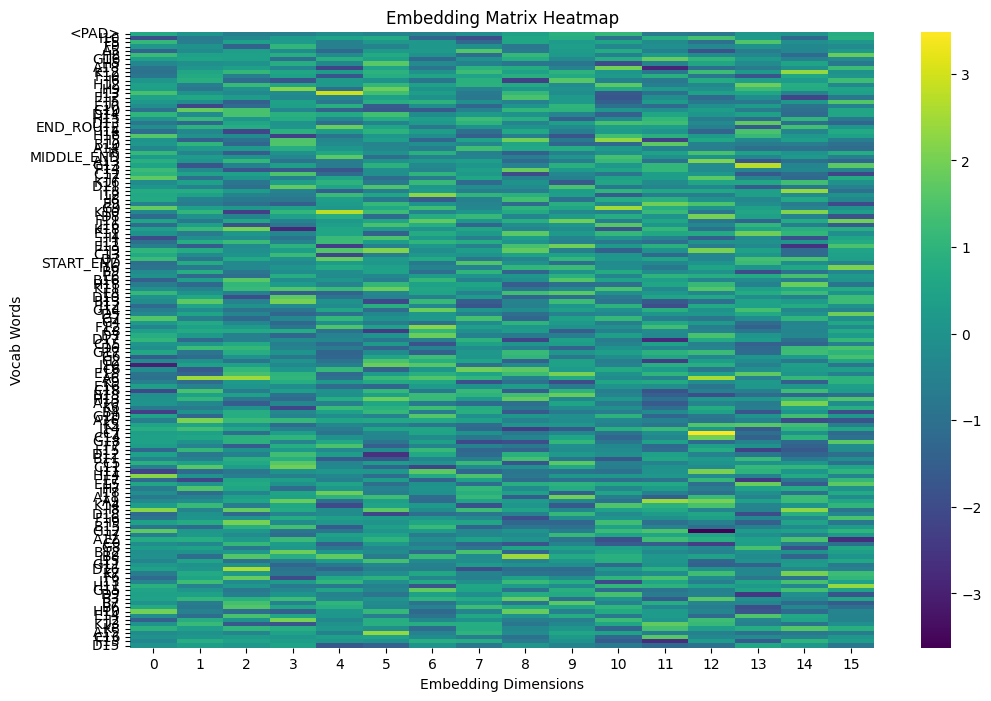

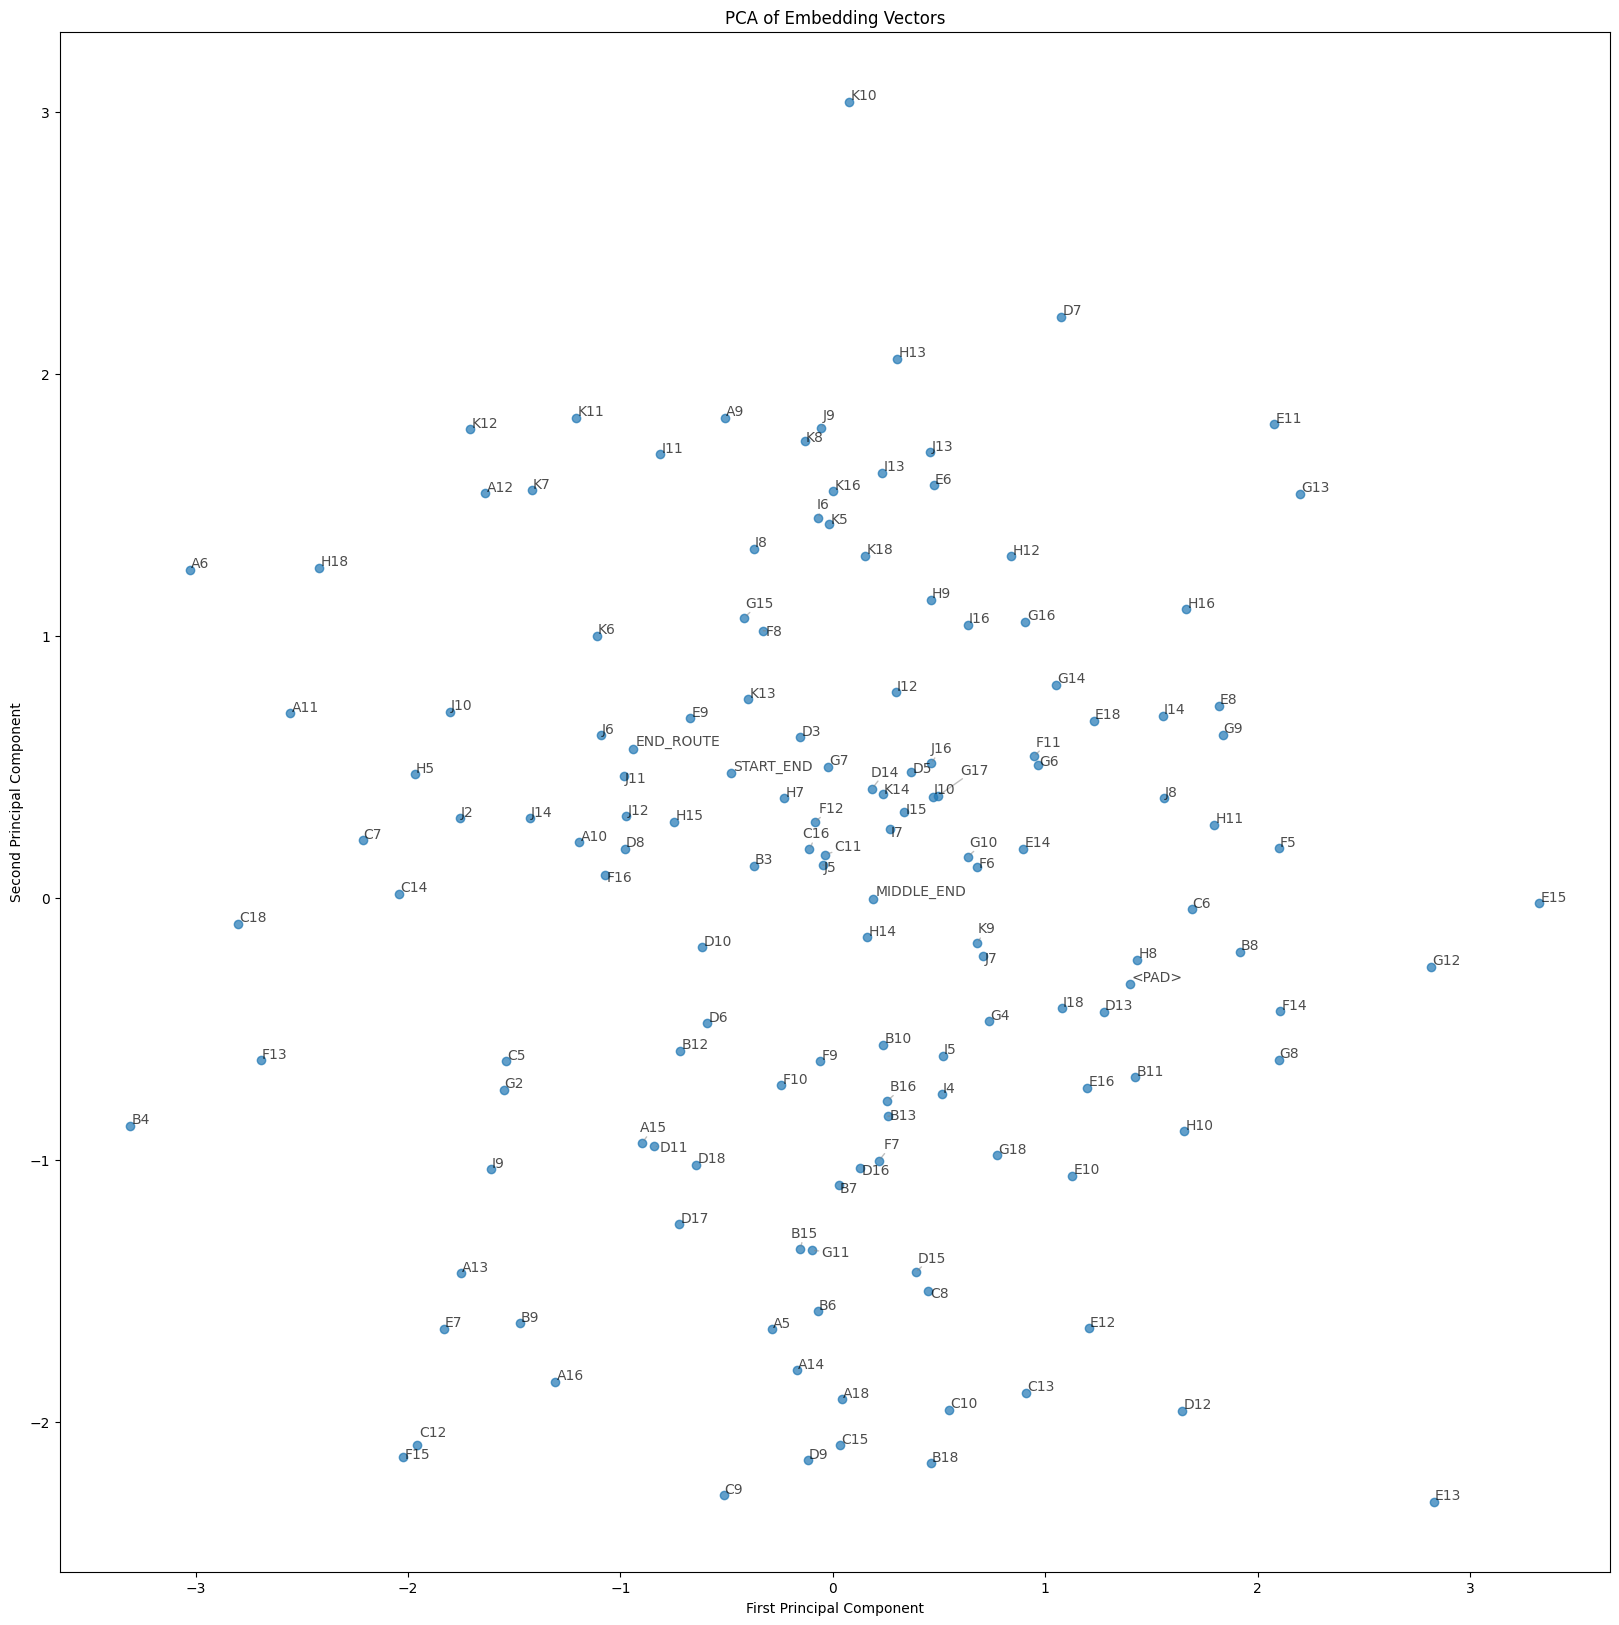

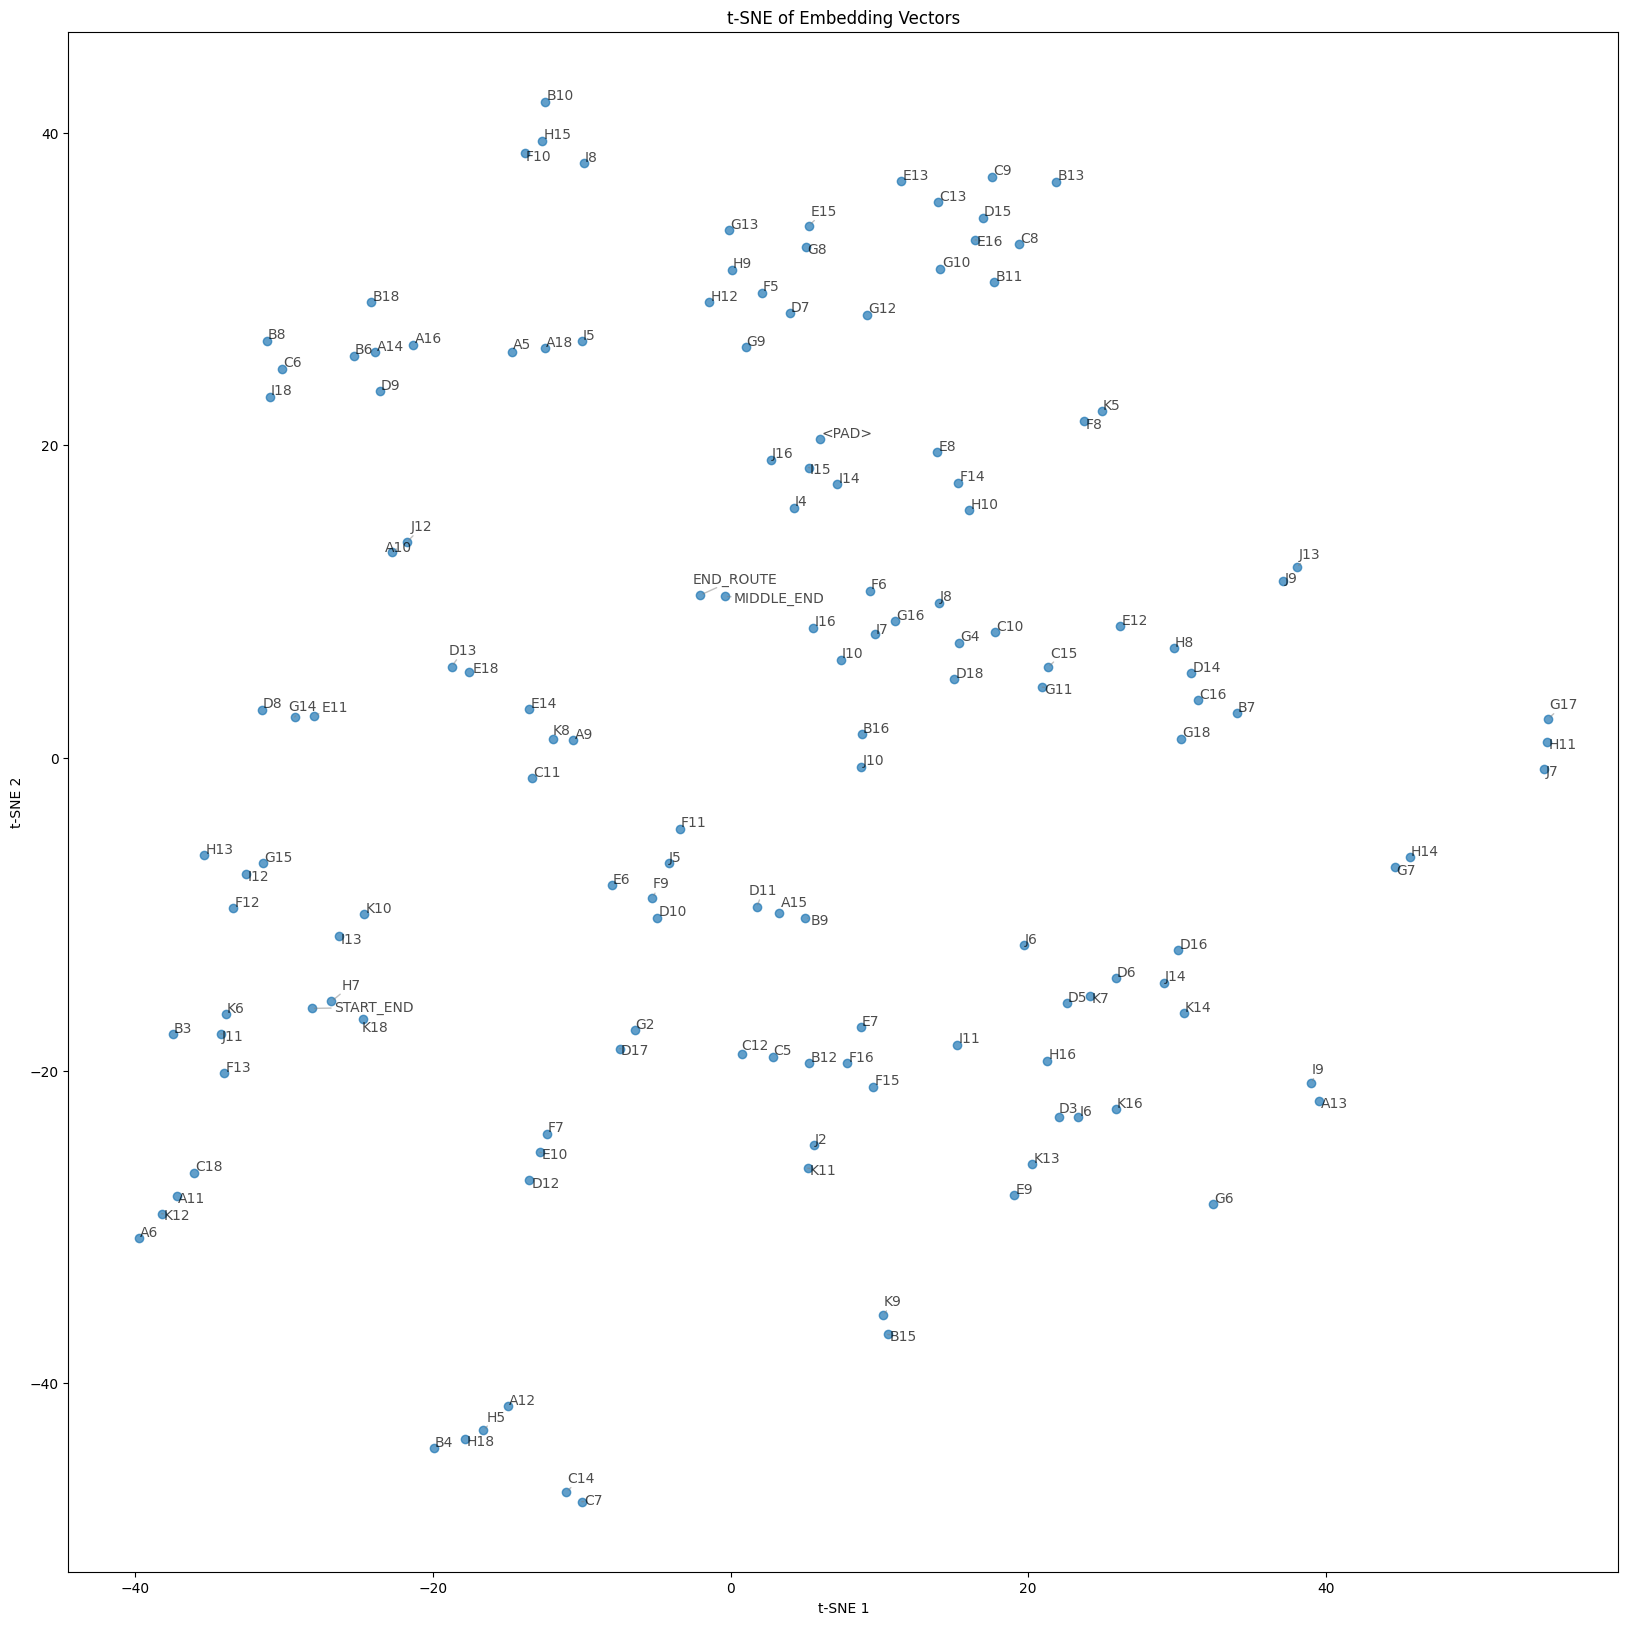

Embedding matrix shape: (145, 16)
Mean value: 0.0008
Standard deviation: 0.9441
Min value: -3.6268
Max value: 3.4867

Cosine similarities between some embedding pairs:
Similarity between <PAD> and I10: -0.1957
Similarity between F5 and F9: -0.0191
Similarity between A5 and H8: -0.2590
Similarity between G16 and H5: -0.2553
Similarity between A18 and K12: 0.1700


In [26]:
!pip install adjustText
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from adjustText import adjust_text  # Import to handle text overlap

# Assuming you have your embedding matrix as a PyTorch module
embedding = model.embedding

# Convert embedding weights to numpy array
embedding_weights = embedding.weight.cpu().detach().numpy()

# Invert vocab dictionary to map indices to words
index_to_word = {idx: word for word, idx in vocab.items()}

def plot_heatmap(weights, vocab):
    plt.figure(figsize=(12, 8))
    # Use vocab indices as y-ticks
    vocab_labels = [index_to_word[i] for i in range(weights.shape[0])]
    sns.heatmap(weights, cmap='viridis', yticklabels=vocab_labels)
    plt.title('Embedding Matrix Heatmap')
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Vocab Words')
    plt.show()

def plot_pca(weights, vocab):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weights)
    
    plt.figure(figsize=(20, 20))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    
    # Annotate points with vocab words and avoid overlap
    texts = [plt.text(pca_result[i, 0], pca_result[i, 1], index_to_word[i], fontsize=10, alpha=0.7) for i in range(pca_result.shape[0])]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5))
    
    plt.title('PCA of Embedding Vectors')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def plot_tsne(weights, vocab):
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)  # Set perplexity to 3
    tsne_result = tsne.fit_transform(weights)
    
    plt.figure(figsize=(20, 20))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    
    # Annotate points with vocab words and avoid overlap
    texts = [plt.text(tsne_result[i, 0], tsne_result[i, 1], index_to_word[i], fontsize=10, alpha=0.7) for i in range(tsne_result.shape[0])]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5))
    
    plt.title('t-SNE of Embedding Vectors')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

def analyze_embeddings(weights, vocab):
    print(f"Embedding matrix shape: {weights.shape}")
    print(f"Mean value: {np.mean(weights):.4f}")
    print(f"Standard deviation: {np.std(weights):.4f}")
    print(f"Min value: {np.min(weights):.4f}")
    print(f"Max value: {np.max(weights):.4f}")
    
    # Compute and print cosine similarities between some pairs of embeddings
    def cosine_similarity(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    print("\nCosine similarities between some embedding pairs:")
    for i in range(0, 10, 2):
        sim = cosine_similarity(weights[i], weights[i+1])
        print(f"Similarity between {index_to_word[i]} and {index_to_word[i+1]}: {sim:.4f}")

# Run the visualization and analysis functions
plot_heatmap(embedding_weights, vocab)
plot_pca(embedding_weights, vocab)
plot_tsne(embedding_weights, vocab)
analyze_embeddings(embedding_weights, vocab)



# Transformer Model?